# Stochastic Models in Finance: TP2
## Réduction de variance
By: 
- Adonis JAMAL
- Ayoub EL KBADI
- Fotios KAPOTOS

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt

In [2]:
# Model values
S0 = 100    # initial stock price
K = 100     # strike price
T = 1.0     # time to maturity in years
r = 0.05    # risk-free rate
sigma = 0.2 # volatility
d = 12      # number of observations
N = 10**5   # number of simulations

In [3]:
# Black Scholes formula for European call option
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Generate asset price paths using Brownian motion
def generate_paths(S0, T, r, sigma, d, N):
    dt = T / d

    # Brownian increments
    Z = np.random.standard_normal((N, d))

    S = np.zeros((N, d + 1))
    S[:, 0] = S0

    drift = (r - 0.5 * sigma**2) * dt
    vol = sigma * np.sqrt(dt)

    for i in range(d):
        S[:, i + 1] = S[:, i] * np.exp(drift + vol * Z[:, i])

    return S

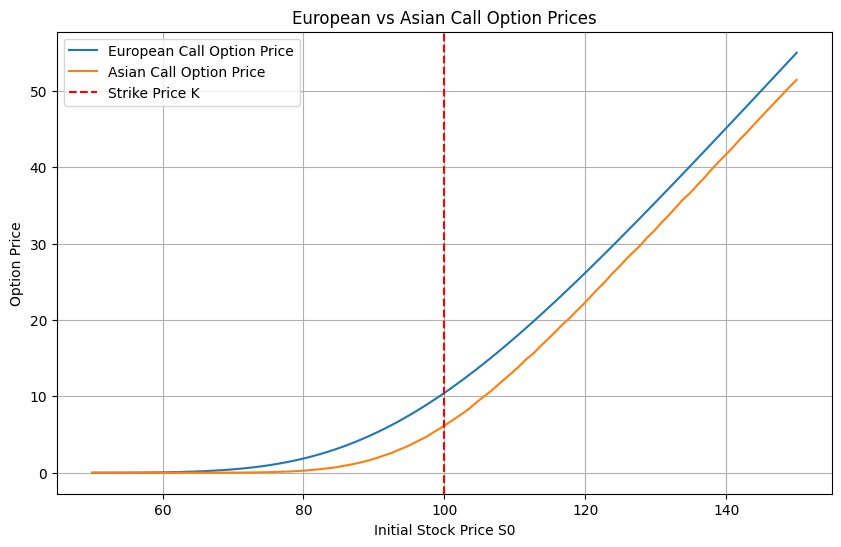

In [4]:
# Comparison of European and Asian Call Options Prices
S0_range = np.linspace(50, 150, 100)
european_prices = []
asian_prices = []

for S0 in S0_range:
    european_prices.append(black_scholes_call(S0, K, T, r, sigma))

    paths = generate_paths(S0, T, r, sigma, d, N)
    average_prices = np.mean(paths[:, 1:], axis=1)
    asian_payoffs = np.maximum(average_prices - K, 0)
    asian_price = np.exp(-r * T) * np.mean(asian_payoffs)
    asian_prices.append(asian_price)

plt.figure(figsize=(10, 6))
plt.plot(S0_range, european_prices, label='European Call Option Price')
plt.plot(S0_range, asian_prices, label='Asian Call Option Price')
plt.axvline(K, color='red', linestyle='--', label='Strike Price K')
plt.title('European vs Asian Call Option Prices')
plt.xlabel('Initial Stock Price S0')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)
plt.show()

L'option asiatique est une option sur la moyenne. Elle sera donc moins volatile que le call européen classique. Par conséquent, son prix sera généralement inférieur à celui du call européen classique, car la moyenne lisse les fluctuations extrêmes du prix du sous-jacent.

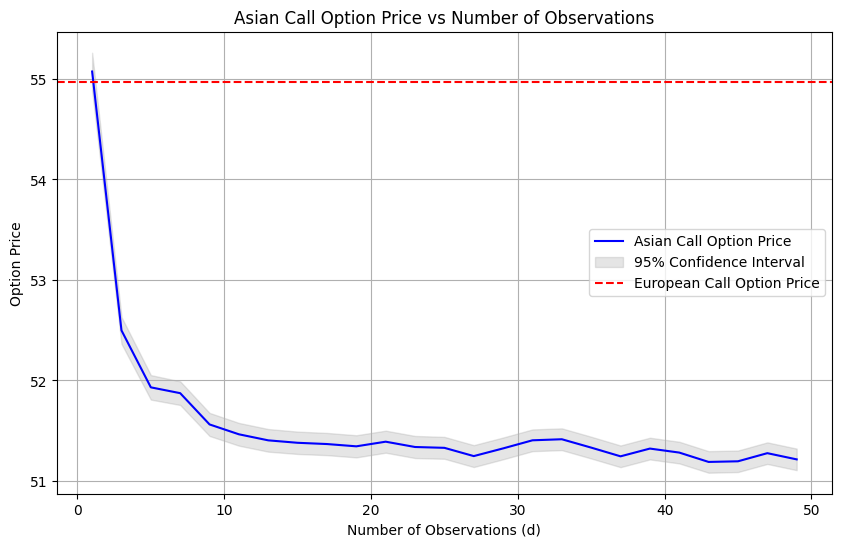

In [5]:
d_values = range(1, 51, 2)
prices = []
ci_widths = []

for d_val in d_values:
    paths = generate_paths(S0, T, r, sigma, d_val, N)
    average_prices = np.mean(paths[:, 1:], axis=1)
    asian_payoffs = np.maximum(average_prices - K, 0)
    asian_price = np.exp(-r * T) * np.mean(asian_payoffs)
    prices.append(asian_price)

    SE = np.std(np.exp(-r * T) * asian_payoffs) / np.sqrt(N)
    ci_width = 1.96 * SE
    ci_widths.append(ci_width)

prices = np.array(prices)
ci_widths = np.array(ci_widths)

plt.figure(figsize=(10, 6))
plt.plot(d_values, prices, 'b-', label='Asian Call Option Price')
plt.fill_between(d_values, prices - ci_widths, prices + ci_widths, color='gray', alpha=0.2, label='95% Confidence Interval')
plt.axhline(black_scholes_call(S0, K, T, r, sigma), color='red', linestyle='--', label='European Call Option Price')
plt.title('Asian Call Option Price vs Number of Observations')
plt.xlabel('Number of Observations (d)')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)
plt.show()

Si d = 1, alors l'option asiatique revient à une option européenne classique, car la moyenne du prix du sous-jacent à un seul instant est simplement le prix à cet instant. Si d augmente, la moyenne devient plus stable et l'option asiatique devient moins sensible aux fluctuations du prix du sous-jacent. Par conséquent, le prix de l'option asiatique diminue avec l'augmentation de d, car la moyenne réduit la volatilité perçue du sous-jacent.

In [6]:
def pricing_with_control_variate(S0, K, T, r, sigma, d, N, type_Z):
    paths = generate_paths(S0, T, r, sigma, d, N)
    average_prices = np.mean(paths[:, 1:], axis=1)
    Y= np.exp(-r * T) * np.maximum(average_prices - K, 0)

    dt = T / d
    times = np.linspace(dt, T, d)

    if type_Z == "ST":
        Z = paths[:, -1]
        E_Z = S0 * np.exp(r * T)
    
    elif type_Z == "Average":
        Z = np.mean(paths[:, 1:], axis=1)
        expected_spots = S0 * np.exp(r * times)
        E_Z = np.mean(expected_spots)

    elif type_Z == "EuroCall":
        ST = paths[:, -1]
        Z = np.exp(-r * T) * np.maximum(ST - K, 0)
        E_Z = black_scholes_call(S0, K, T, r, sigma)

    cov_matrix = np.cov(Y, Z)
    cov_YZ = cov_matrix[0, 1]
    var_Z = cov_matrix[1, 1]
    c_star = cov_YZ / var_Z

    Y_cv = Y - c_star * (Z - E_Z)

    price_mc = np.mean(Y)
    price_cv = np.mean(Y_cv)
    Var_Y = np.var(Y)
    Var_Y_cv = np.var(Y_cv)

    ratio = Var_Y / Var_Y_cv

    rho = np.corrcoef(Y, Z)[0, 1]
    theoretical_ratio = 1 / (1 - rho**2)

    return {
        "Type": type_Z,
        "Standard MC Price": price_mc,
        "Control Variate Price": price_cv,
        "Standard MC Variance": Var_Y,
        "Control Variate Variance": Var_Y_cv,
        "Variance Reduction Ratio (Empirical)": ratio,
        "Correlation": rho
    }

In [7]:
# Z = S_T
print(f"{'Type Z':<15} | {'Price':<10} | {'Variance Reduction Ratio':<10} | {'Correlation':<10}")
res_ST = pricing_with_control_variate(S0, K, T, r, sigma, d, N, "ST")
print(f"{res_ST['Type']:<15} | {res_ST['Control Variate Price']:<10.4f} | {res_ST['Variance Reduction Ratio (Empirical)']:<24.2f} | {res_ST['Correlation']:<.4f}")

# Z = Average Price
res_Average = pricing_with_control_variate(S0, K, T, r, sigma, d, N, "Average")
print(f"{res_Average['Type']:<15} | {res_Average['Control Variate Price']:<10.4f} | {res_Average['Variance Reduction Ratio (Empirical)']:<24.2f} | {res_Average['Correlation']:<.4f}")

# Z = European Call Price
res_EuroCall = pricing_with_control_variate(S0, K, T, r, sigma, d, N, "EuroCall")
print(f"{res_EuroCall['Type']:<15} | {res_EuroCall['Control Variate Price']:<10.4f} | {res_EuroCall['Variance Reduction Ratio (Empirical)']:<24.2f} | {res_EuroCall['Correlation']:<.4f}")

Type Z          | Price      | Variance Reduction Ratio | Correlation
ST              | 51.4700    | 4.56                     | 0.8835
Average         | 51.4943    | 133386.17                | 1.0000
EuroCall        | 51.5527    | 4.52                     | 0.8825


Question 3 :\
La corrélation est positive et autour de 0.9. La réduction de variance est donc efficace ici, car le contrôle utilisé (prix du sous-jacent à maturité) est fortement corrélé avec la variable d'intérêt (payoff de l'option asiatique).

Question 4 :\
Pour la moyenne, la corrélation vaut 1 et le facteur de réduction de variance est extrêmement élevé. Cela signifie que l'estimateur avec contrôle élimine presque toute la variance, conduisant à une estimation très précise du prix de l'option asiatique.\
Pour l'eurocall, les résultats sont très similaires à ceux de la question 3, les deux options réagissent de la meme manière aux mouvements du marché.

In [8]:
def pricing_with_multiple_control_variates(S0, K, T, r, sigma, d, N):
    paths = generate_paths(S0, T, r, sigma, d, N)
    average_prices = np.mean(paths[:, 1:], axis=1)
    Y= np.exp(-r * T) * np.maximum(average_prices - K, 0)

    dt = T / d
    times = np.linspace(dt, T, d)

    # Spot average
    Z1 = np.mean(paths[:, 1:], axis=1)
    E_Z1 = np.mean(S0 * np.exp(r * times))

    # Final price ST
    Z2 = paths[:, -1]
    E_Z2 = S0 * np.exp(r * T)

    # European Call Price
    Z3 = np.exp(-r * T) * np.maximum(Z2 - K, 0)
    E_Z3 = black_scholes_call(S0, K, T, r, sigma)

    Controls = np.vstack([Z1 - E_Z1, Z2 - E_Z2, Z3 - E_Z3]).T
    covariance_matrix = np.cov(np.hstack([Y.reshape(-1, 1), Controls]).T)

    Sigma_ZZ = covariance_matrix[1:, 1:]
    Sigma_YZ = covariance_matrix[0, 1:]

    c_star = np.linalg.solve(Sigma_ZZ, Sigma_YZ)
    print(f"Optimal coefficients c*: {c_star}")

    adjustment = np.dot(Controls, c_star)
    Y_cv = Y - adjustment

    var_Y = np.var(Y)
    var_Y_cv = np.var(Y_cv)
    reduction_factor = var_Y / var_Y_cv

    return np.mean(Y_cv), reduction_factor

In [9]:
price_multi_cv, reduction_factor_multi = pricing_with_multiple_control_variates(S0, K, T, r, sigma, d, N)
print(f"Asian option price with Multiple Control Variates: {price_multi_cv:.4f}")
print(f"Variance Reduction Factor with Multiple Control Variates: {reduction_factor_multi:.2f}")

Optimal coefficients c*: [ 0.95120342 -0.00579446  0.00612385]
Asian option price with Multiple Control Variates: 51.4941
Variance Reduction Factor with Multiple Control Variates: 382419.89


On a un facteur de réduction de variance extrêmement élevé avec les trois variables de contrôle. Cela montre que l'utilisation conjointe des trois contrôles améliore significativement la précision de l'estimation du prix de l'option asiatique par rapport à l'utilisation d'un seul contrôle.

In [10]:
def exact_geometric_asian_option_price(S0, K, T, r, sigma, d):
    dt = T / d
    times = np.linspace(dt, T, d)

    mu_G = np.log(S0) + ( r - 0.5 * sigma**2) * np.mean(times)

    sum_cov = 0
    for ti in times:
        for tj in times:
            sum_cov += min(ti, tj)

    var_G = (sigma**2 / d**2) * sum_cov
    sigma_G = np.sqrt(var_G)

    d1 = (mu_G - np.log(K) + var_G) / sigma_G
    d2 = d1 - sigma_G

    price = np.exp(-r * T) * (np.exp(mu_G + 0.5 * var_G) * norm.cdf(d1) - K * norm.cdf(d2))
    return price


def monte_carlo_geometric(S0, K, T, r, sigma, d, N):
    paths = generate_paths(S0, T, r, sigma, d, N)

    log_paths = np.log(paths[:, 1:])
    G_T = np.exp(np.mean(log_paths, axis=1))

    payoffs = np.exp(-r * T) * np.maximum(G_T - K, 0)
    price = np.mean(payoffs)

    se = np.std(payoffs) / np.sqrt(N)
    return price, price - 1.96 * se, price + 1.96 * se

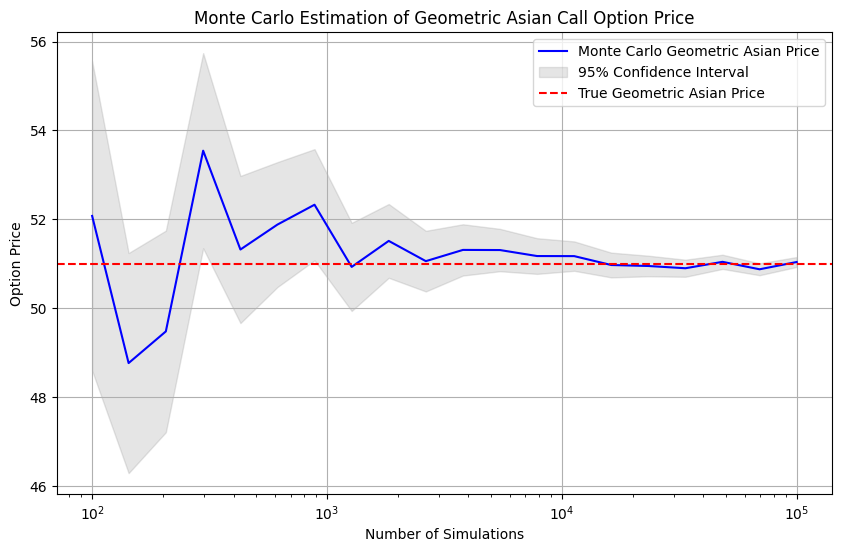

In [11]:
# Asiactic Geometric Option Price
true_geo_price = exact_geometric_asian_option_price(S0, K, T, r, sigma, d)

N_vec_geo = np.logspace(2, 5, 20, dtype=int)
mc_geo_prices = []
mc_geo_ci = []

for N_val in N_vec_geo:
    price, low, N_high = monte_carlo_geometric(S0, K, T, r, sigma, d, N_val)
    mc_geo_prices.append(price)
    mc_geo_ci.append((low, N_high))

mc_geo_prices = np.array(mc_geo_prices)
lows = [x[0] for x in mc_geo_ci]
highs = [x[1] for x in mc_geo_ci]

plt.figure(figsize=(10, 6))
plt.plot(N_vec_geo, mc_geo_prices, 'b-', label='Monte Carlo Geometric Asian Price')
plt.fill_between(N_vec_geo, lows, highs, color='gray', alpha=0.2, label='95% Confidence Interval')
plt.axhline(true_geo_price, color='red', linestyle='--', label='True Geometric Asian Price')
plt.xscale('log')
plt.title('Monte Carlo Estimation of Geometric Asian Call Option Price')
plt.xlabel('Number of Simulations')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)
plt.show()

Bonus: Montrons pourquoi on parle d'option asiatique géométrique.
Nous allons en particulier montrer que l'option asiatique arithmétique et l'option asiatique géométrique sont corrélées à 99%.

In [12]:
def pricing_arithmetic_with_geo_control(S0, K, T, r, sigma, d, N):
    paths = generate_paths(S0, T, r, sigma, d, N)
    prices_path = paths[:, 1:]

    mean_arith = np.mean(prices_path, axis=1)
    Y = np.exp(-r * T) * np.maximum(mean_arith - K, 0)

    mean_geo = np.exp(np.mean(np.log(prices_path), axis=1))
    Z = np.exp(-r * T) * np.maximum(mean_geo - K, 0)
    E_Z = exact_geometric_asian_option_price(S0, K, T, r, sigma, d)

    cov_matrix = np.cov(Y, Z)
    cov_YZ = cov_matrix[0, 1]
    var_Z = cov_matrix[1, 1]
    c_star = cov_YZ / var_Z

    Y_cv = Y - c_star * (Z - E_Z)

    price_std = np.mean(Y)
    price_cv = np.mean(Y_cv)
    var_std = np.var(Y)
    var_cv = np.var(Y_cv)
    rho = np.corrcoef(Y, Z)[0, 1]
    
    return price_std, price_cv, var_std, var_cv, rho

In [13]:
price_std, price_cv, var_std, var_cv, rho = pricing_arithmetic_with_geo_control(S0, K, T, r, sigma, d, N)

print(f"Correlation between Arithmetic and Geometric Asian Payoffs: {rho:.6f}")
print(f"Standard MC Price: {price_std:.4f} | Variance: {var_std:.6f}")
print(f"Control Variate MC Price: {price_cv:.4f} | Variance: {var_cv:.6f}")
print(f"Variance Reduction Factor: {var_std / var_cv:.2f}")

Correlation between Arithmetic and Geometric Asian Payoffs: 0.999668
Standard MC Price: 51.5420 | Variance: 329.156096
Control Variate MC Price: 51.4928 | Variance: 0.218409
Variance Reduction Factor: 1507.06


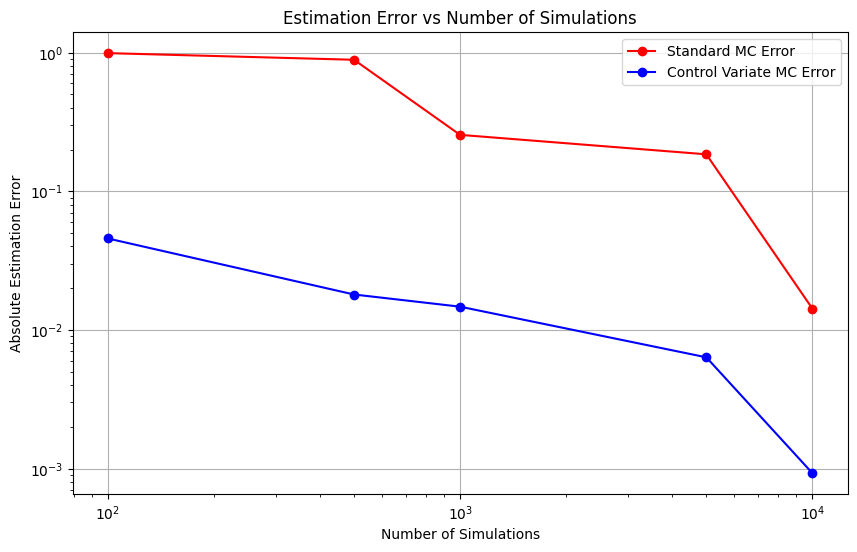

In [14]:
N_vec = [100, 500, 1000, 5000, 10000]
std_errors = []
cv_errors = []

ref_price, _, _, _, _ = pricing_arithmetic_with_geo_control(S0, K, T, r, sigma, d, 5*10**6)

for N_val in N_vec:
    price_std, price_cv, _, _, _ = pricing_arithmetic_with_geo_control(S0, K, T, r, sigma, d, N_val)
    std_errors.append(abs(price_std - ref_price))
    cv_errors.append(abs(price_cv - ref_price))

plt.figure(figsize=(10, 6))
plt.plot(N_vec, std_errors, 'r-o', label='Standard MC Error')
plt.plot(N_vec, cv_errors, 'b-o', label='Control Variate MC Error')
plt.yscale('log')
plt.xscale('log')
plt.title('Estimation Error vs Number of Simulations')
plt.xlabel('Number of Simulations')
plt.ylabel('Absolute Estimation Error')
plt.legend()
plt.grid(True)
plt.show()